In [ ]:
pip install pennylane scikit-learn matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 18.2 MB/s eta 0:00:00


In [ ]:
pip install plotly==5.22.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 21.5 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.24.1
    Uninstalling plotly-5.24.1:
      Successfully uninstalled plotly-5.24.1


In [ ]:
pip install nbformat>=4.2.0

QSVM train accuracy: 0.84
Points inside the local patch (r = 1.0): 30
step   0 | loss = 0.758846
step  10 | loss = 0.075094
step  20 | loss = 0.038120
step  30 | loss = 0.028621
step  40 | loss = 0.027143
step  50 | loss = 0.025521
step  60 | loss = 0.025135
step  70 | loss = 0.025000
step  80 | loss = 0.024992
step  90 | loss = 0.024989
Reuploading depth L  : 2
Local Q-surrogate R² : 0.9403742966912275
Global Q-surrogate R²: -0.33206835080501373
Local classical R²: 1.0


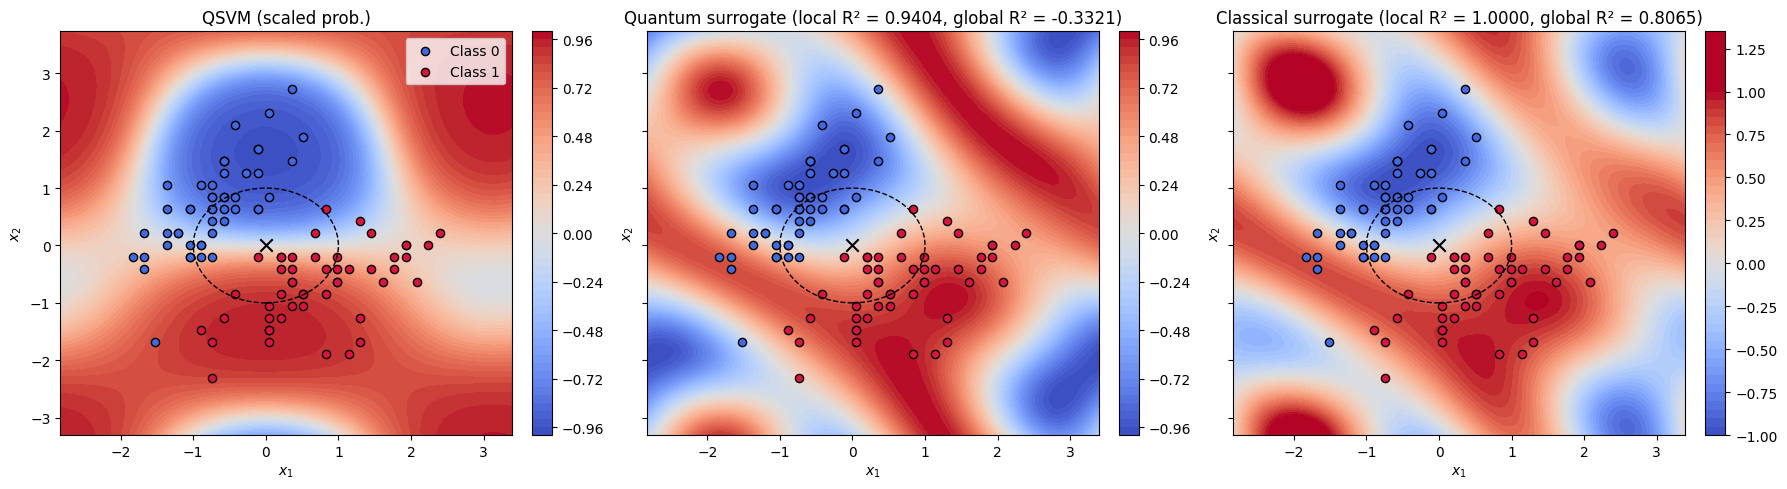

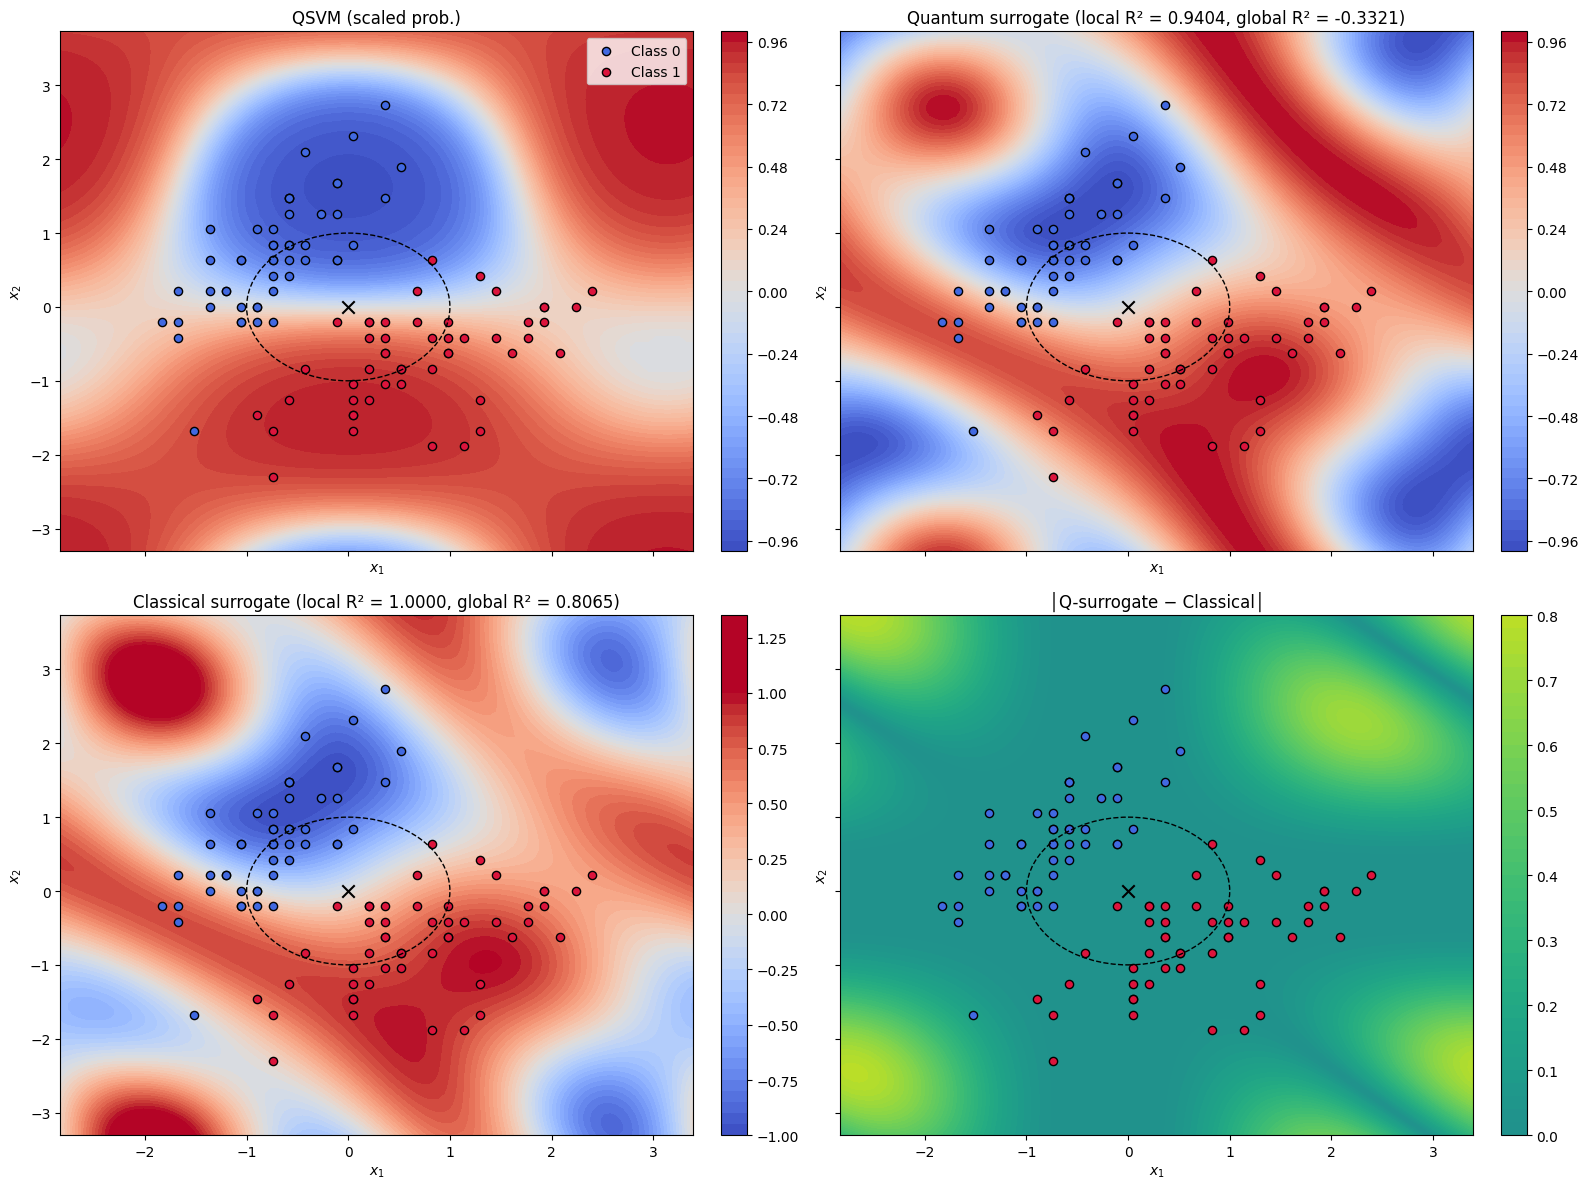

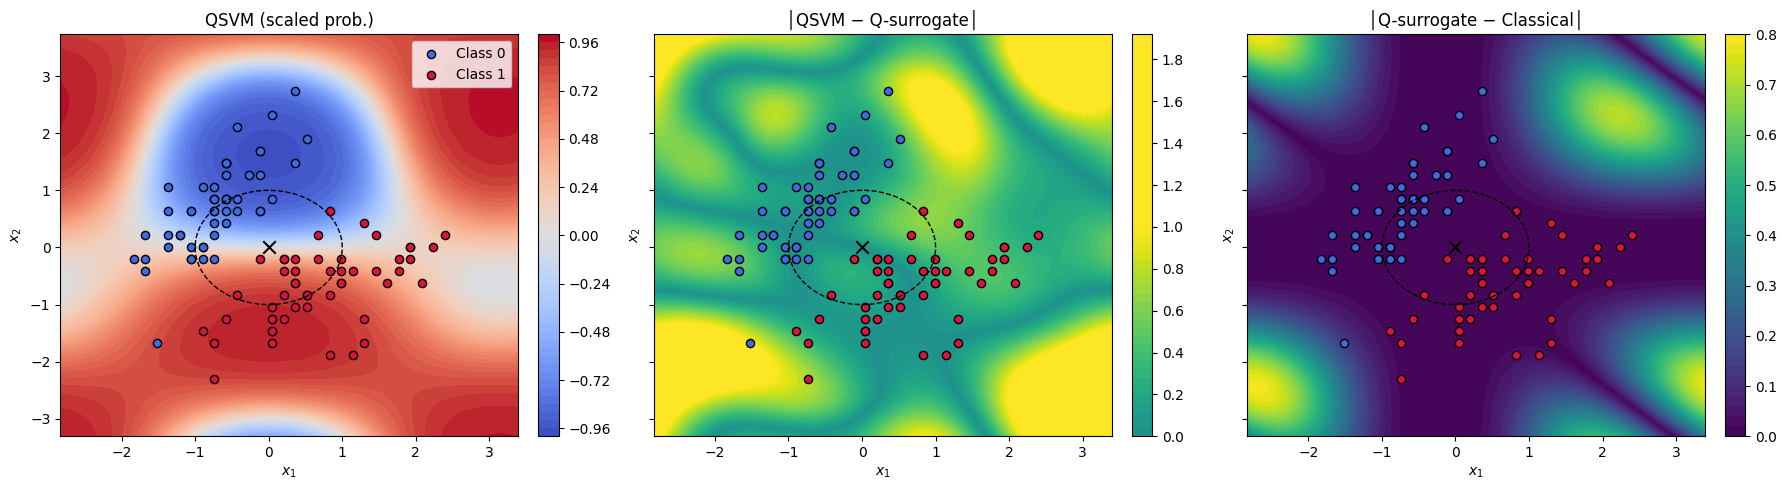

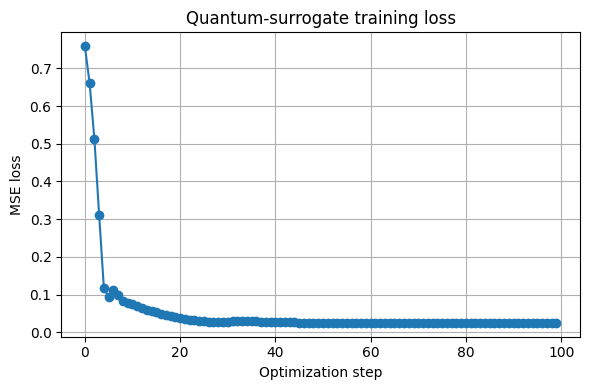


Summary metrics
  QSVM → Q-surrogate : local R² = 0.9404, global R² = -0.3321
  Q-surrogate → Classical : local R² = 1.0000, global R² = 0.8065


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from numpy.linalg import lstsq
# fft imports kept for completeness
from numpy.fft import fft2, fftshift, ifft2

# ───────────────────── 1.  data ─────────────────────
iris = datasets.load_iris()
X, y = iris.data[:, :2], iris.target
mask = y < 2                     # classes 0 & 1 only
X, y = X[mask], y[mask]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

clr0, clr1 = "royalblue", "crimson"     # colours for scatter points

# ── QSVM section ─────────────────────────────────────────────
n_qubits_kernel = 2                       # <── keep this local
dev_k = qml.device("default.qubit", wires=n_qubits_kernel)

@qml.qnode(dev_k)
def kernel_circuit(x1, x2):
    qml.AngleEmbedding(x1, wires=range(n_qubits_kernel))
    qml.BasicEntanglerLayers([np.ones(n_qubits_kernel)], wires=range(n_qubits_kernel))
    qml.adjoint(qml.AngleEmbedding)(x2, wires=range(n_qubits_kernel))
    qml.adjoint(qml.BasicEntanglerLayers)([np.ones(n_qubits_kernel)], wires=range(n_qubits_kernel))
    return qml.probs(wires=range(n_qubits_kernel))

def quantum_kernel(A, B=None):
    B = A if B is None else B
    K = np.zeros((len(A), len(B)))
    for i,a in enumerate(A):
        for j,b in enumerate(B):
            K[i,j] = kernel_circuit(a,b)[0]
    return K

qsvm = SVC(kernel=quantum_kernel, probability=True)
qsvm.fit(X_scaled, y)
print("QSVM train accuracy:", qsvm.score(X_scaled, y))

# ───────────────────── 3.  local region ─────────────────────
centre = np.array([0.0, 0.0])
radius = 1.0
loc      = np.linalg.norm(X_scaled - centre, axis=1) < radius
X_local  = X_scaled[loc]
z_local  = qsvm.predict_proba(X_local)[:, 1] * 2 - 1  # ∈ [−1,1]

print(f"Points inside the local patch (r = {radius}): {len(X_local)}")

# ── single-qubit surrogate section ───────────────────────────
n_qubits_sur   = 1                       # <── different name
n_reuploads    = 2
n_var_layers   = 1
dev_s          = qml.device("default.qubit", wires=n_qubits_sur)


def feature_map(x):
    """Encode (x1,x2) sequentially on the single qubit."""
    qml.RY(x[0], wires=0)
    qml.RZ(x[1], wires=0)          # or RY/RX — any phase-free axis works

def var_block(weights):
    qml.StronglyEntanglingLayers(weights, wires=[0])

@qml.qnode(dev_s)
def surr_qnode(x, W):
    for ℓ in range(n_reuploads):
        feature_map(x)             # data upload
        var_block(W[ℓ])            # 6 angles per upload even on 1 qubit
    return qml.expval(qml.PauliZ(0))


# helper wrappers ------------------------------------------------------
def surr_Q(X, W):
    """Vectorised surrogate prediction."""
    return np.array([surr_qnode(xi, W) for xi in X])

def mse(W):
    """MSE loss on the local QSVM labels."""
    return np.mean((surr_Q(X_local, W) - z_local) ** 2)

# trainable parameters -------------------------------------------------
np.random.seed(42)
W = qml.numpy.array(
        0.01 * np.random.randn(n_reuploads, n_var_layers, n_qubits_sur, 3),
        requires_grad=True,
    )

opt = qml.optimize.NesterovMomentumOptimizer(0.5)
loss_history = []

for step in range(100):
    loss_history.append(mse(W))
    W = opt.step(mse, W)
    if step % 10 == 0:
        print(f"step {step:3d} | loss = {loss_history[-1]:.6f}")

print(f"Reuploading depth L  : {n_reuploads}")
print("Local Q-surrogate R² :", r2_score(z_local, surr_Q(X_local, W)))


# ───────────────────── 5.  global grid ─────────────────────
xx, yy = np.meshgrid(
    np.linspace(X_scaled[:, 0].min()-1, X_scaled[:, 0].max()+1, 100),
    np.linspace(X_scaled[:, 1].min()-1, X_scaled[:, 1].max()+1, 100)
)
grid = np.c_[xx.ravel(), yy.ravel()]

z_qsvm = qsvm.predict_proba(grid)[:, 1]*2 - 1
z_qsur = surr_Q(grid, W)                 # ← fixed
surf_qsvm = z_qsvm.reshape(xx.shape)
surf_qsur = z_qsur.reshape(xx.shape)
print("Global Q-surrogate R²:", r2_score(z_qsvm, z_qsur))

# ───────────────────── 6.  classical (Fourier) surrogate ─────────────────────
def fourier_basis(X, M=n_reuploads):   # modified to treat the local q surrogate as a white box
    rows, rng = [], range(-M, M+1)
    for i in rng:
        for j in rng:
            rows.append(np.exp(1j*(i*X[:, 0] + j*X[:, 1])))
    return np.stack(rows, axis=1)

Phi_loc = fourier_basis(X_local)
coeffs, *_ = lstsq(Phi_loc, surr_Q(X_local, W), rcond=None)  # ← fixed
def surr_C(X): return np.real(fourier_basis(X) @ coeffs)

surf_csur = surr_C(grid).reshape(xx.shape)
print("Local classical R²:", r2_score(surr_Q(X_local, W), surr_C(X_local)))  # ← fixed

# helper to scatter the iris points
def scatter_points(ax):
    ax.scatter(X_scaled[y==0,0], X_scaled[y==0,1], c=clr0, edgecolor='k',
               s=35, label='Class 0')
    ax.scatter(X_scaled[y==1,0], X_scaled[y==1,1], c=clr1, edgecolor='k',
               s=35, label='Class 1')

# helper to scatter the iris points (unchanged) …
# -------------------------------------------------------------------------

# ───────────────────── 7.  three-panel figure ─────────────────────
fig1, axes1 = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)
titles1 = [
    "QSVM (scaled prob.)",
    f"Quantum surrogate (local R² = {r2_score(z_local, surr_Q(X_local, W)):.4f}, "
    f"global R² = {r2_score(surf_qsvm.ravel(), surf_qsur.ravel()):.4f})",
    f"Classical surrogate (local R² = {r2_score(surr_Q(X_local, W), surr_C(X_local)):.4f}, "
    f"global R² = {r2_score(surf_qsur.ravel(), surf_csur.ravel()):.4f})"
]
arrays1 = [surf_qsvm, surf_qsur, surf_csur]
cmaps1  = ["coolwarm"]*3

for k,(ax,Z,t,c) in enumerate(zip(axes1, arrays1, titles1, cmaps1)):
    im = ax.contourf(xx,yy,Z,50,cmap=c,
                     vmin=-1 if "surrogate" in t or "QSVM" in t else 0,
                     vmax= 1 if "surrogate" in t or "QSVM" in t else None)
    scatter_points(ax)
    ax.scatter(*centre,marker='x',c='k',s=80)
    ax.add_patch(mpatches.Circle(centre,radius,fill=False,linestyle='--'))
    ax.set_title(t); ax.set_xlabel("$x_1$"); ax.set_ylabel("$x_2$")
    if k==0: ax.legend()
    fig1.colorbar(im, ax=ax, fraction=.046, pad=.04)
plt.tight_layout(); plt.show()

# ───────────────────── 8. 2×2 composite ─────────────────────
fig2, axes2 = plt.subplots(2,2, figsize=(16,12), sharex=True, sharey=True)
titles2 = ["QSVM (scaled prob.)",f"Quantum surrogate (local R² = {r2_score(z_local, surr_Q(X_local, W)):.4f}, global R² = {r2_score(surf_qsvm.ravel(), surf_qsur.ravel()):.4f})",
           f"Classical surrogate (local R² = {r2_score(surr_Q(X_local, W), surr_C(X_local)):.4f}, global R² = {r2_score(surf_qsur.ravel(), surf_csur.ravel()):.4f})","│Q-surrogate − Classical│"]
arrays2 = [surf_qsvm, surf_qsur, surf_csur,
           np.abs(surf_qsur - surf_csur)]
cmaps2  = ["coolwarm","coolwarm","coolwarm","viridis"]

for k,(ax,Z,t,c) in enumerate(zip(axes2.ravel(), arrays2, titles2, cmaps2)):
    im = ax.contourf(xx,yy,Z,50,cmap=c,
                     vmin=-1 if "surrogate" in t or "QSVM" in t else 0,
                     vmax= 1 if "surrogate" in t or "QSVM" in t else None)
    scatter_points(ax)
    ax.scatter(*centre,marker='x',c='k',s=80)
    ax.add_patch(mpatches.Circle(centre,radius,fill=False,linestyle='--'))
    ax.set_title(t); ax.set_xlabel("$x_1$"); ax.set_ylabel("$x_2$")
    if k==0: ax.legend()
    fig2.colorbar(im, ax=ax, fraction=.046, pad=.04)
plt.tight_layout(); plt.show()

# ───────────────────── 9. surrogate-chain figure ─────────────────────
fig3, axes3 = plt.subplots(1,3, figsize=(18,5), sharex=True, sharey=True)
titles3 = ["QSVM (scaled prob.)",
           "│QSVM − Q-surrogate│",
           "│Q-surrogate − Classical│"]
arrays3 = [surf_qsvm,
           np.abs(surf_qsvm - surf_qsur),
           np.abs(surf_qsur - surf_csur)]
cmaps3  = ["coolwarm","viridis","viridis"]


for k,(ax,Z,t,c) in enumerate(zip(axes3, arrays3, titles3, cmaps3)):
    im = ax.contourf(xx,yy,Z,50,cmap=c,
                     vmin=-1 if "QSVM" in t else 0,
                     vmax= 1 if "QSVM" in t else None)
    scatter_points(ax)
    ax.scatter(*centre,marker='x',c='k',s=80)
    ax.add_patch(mpatches.Circle(centre,radius,fill=False,linestyle='--'))
    ax.set_title(t); ax.set_xlabel("$x_1$"); ax.set_ylabel("$x_2$")
    if k==0: ax.legend()
    fig3.colorbar(im, ax=ax, fraction=.046, pad=.04)
plt.tight_layout(); plt.show()

# ───────────────────── 10. step-loss curve ─────────────────────
plt.figure(figsize=(6,4))
plt.plot(range(len(loss_history)), loss_history, marker='o')
plt.title("Quantum-surrogate training loss")
plt.xlabel("Optimization step")
plt.ylabel("MSE loss")
plt.grid(True)
plt.tight_layout(); plt.show()

# ───────────────────── 11.  summary metrics ─────────────────────
print("\nSummary metrics")
print(f"  QSVM → Q-surrogate : local R² = {r2_score(z_local, surr_Q(X_local, W)):.4f}"
      f", global R² = {r2_score(surf_qsvm.ravel(), surf_qsur.ravel()):.4f}")
print(f"  Q-surrogate → Classical : local R² = {r2_score(surr_Q(X_local, W), surr_C(X_local)):.4f}"
      f", global R² = {r2_score(surf_qsur.ravel(), surf_csur.ravel()):.4f}")

In [ ]:
"""
Local surrogation sweep over multiple patch radii.
Prints:
  – number of Iris samples in the patch
  – step-vs-loss table (every 10 steps)
  – R²(Q-surrogate → QSVM)   local & global
  – R²(classical → Q-surrogate) local & global
"""

import pennylane as qml, matplotlib.pyplot as plt
from pennylane import numpy as np
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from numpy.linalg import lstsq

# ───────────────────── 1.  Iris data  ─────────────────────────
iris   = datasets.load_iris()
X, y   = iris.data[:, :2], iris.target
X, y   = X[y < 2], y[y < 2]                 # two classes, two features
X      = StandardScaler().fit_transform(X)  # shape (100,2)

# ───────────────────── 2.  QSVM (2-qubit kernel)  ─────────────
nq_k   = 2
dev_k  = qml.device("default.qubit", wires=nq_k)

@qml.qnode(dev_k)
def k_circ(x1, x2):
    qml.AngleEmbedding(x1, wires=range(nq_k))
    qml.BasicEntanglerLayers([np.ones(nq_k)], wires=range(nq_k))
    qml.adjoint(qml.AngleEmbedding)(x2, wires=range(nq_k))
    qml.adjoint(qml.BasicEntanglerLayers)([np.ones(nq_k)], wires=range(nq_k))
    return qml.probs(wires=range(nq_k))

def q_kernel(A, B=None):
    B = A if B is None else B
    K = np.zeros((len(A), len(B)))
    for i, a in enumerate(A):
        for j, b in enumerate(B):
            K[i, j] = k_circ(a, b)[0]
    return K

qsvm = SVC(kernel=q_kernel, probability=True).fit(X, y)
print("QSVM train accuracy =", qsvm.score(X, y))

# ───────────────────── 3.  global mesh (coarse)  ──────────────
GRID_N = 40                                             # 40×40 = 1600 pts
xx, yy = np.meshgrid(np.linspace(X[:,0].min()-1, X[:,0].max()+1, GRID_N),
                     np.linspace(X[:,1].min()-1, X[:,1].max()+1, GRID_N))
grid   = np.c_[xx.ravel(), yy.ravel()]
print(f"Global grid: {len(grid)} points → kernel {len(grid)}×{len(X)}")
z_qsvm = qsvm.predict_proba(grid)[:, 1]*2 - 1           # 160 000 calls

# ───────────────────── 4.  sweep over radii  ────────────────
radii  = np.linspace(0.3, 2.5, 20)          # customise as needed
centre = np.array([0.0, 0.0])

for r in radii:
    # ----------  patch  ----------
    mask_loc = np.linalg.norm(X - centre, axis=1) < r
    X_loc    = X[mask_loc]
    z_loc    = qsvm.predict_proba(X_loc)[:, 1]*2 - 1
    n_pts    = len(X_loc)

    # ----------  1-qubit surrogate  ----------
    nq_s, L, layers = 1, 2, 1
    dev_s = qml.device("default.qubit", wires=[0])

    def f_map(x): qml.RY(x[0], 0); qml.RZ(x[1], 0)
    def v_block(w): qml.StronglyEntanglingLayers(w, wires=[0])

    @qml.qnode(dev_s)
    def q_surr(x, W):
        for ℓ in range(L):
            f_map(x); v_block(W[ℓ])
        return qml.expval(qml.PauliZ(0))

    q_vec = lambda X_, W: np.array([q_surr(x, W) for x in X_])

    np.random.seed(0)
    W = qml.numpy.array(0.01*np.random.randn(L, layers, nq_s, 3),
                        requires_grad=True)
    opt = qml.optimize.NesterovMomentumOptimizer(0.5)

    loss_hist = []
    for step in range(100):
        loss = np.mean((q_vec(X_loc, W) - z_loc)**2)
        loss_hist.append(loss)
        W = opt.step(lambda w: np.mean((q_vec(X_loc, w) - z_loc)**2), W)

    # ----------  Fourier surrogate (cube, M=L)  ----------
    def fourier_basis(X_, M=L):
        return np.stack([np.exp(1j*(i*X_[:,0]+j*X_[:,1]))
                         for i in range(-M, M+1)
                         for j in range(-M, M+1)], axis=1)

    coeffs, *_ = lstsq(fourier_basis(X_loc), q_vec(X_loc, W), rcond=None)
    surr_C     = lambda X_: np.real(fourier_basis(X_) @ coeffs)

    # ----------  metrics  ----------
    z_q_loc, z_q_glb = q_vec(X_loc, W), q_vec(grid, W)
    z_c_loc, z_c_glb = surr_C(X_loc),  surr_C(grid)

    R2_QT_loc = r2_score(z_loc,   z_q_loc)
    R2_QT_glb = r2_score(z_qsvm,  z_q_glb)
    R2_CQ_loc = r2_score(z_q_loc, z_c_loc)
    R2_CQ_glb = r2_score(z_q_glb, z_c_glb)

    # ----------  console output  ----------
    print(f"\nRadius r = {r:.2f}   |   patch points = {n_pts}")
    print(" step |   loss")
    for s in range(0, 60, 1):
        print(f"{s:4d} | {loss_hist[s]:.6f}")
    print(f" 99  | {loss_hist[-1]:.6f}")

    print(f" R² Q→T  (local, global) = ({R2_QT_loc:.3f}, {R2_QT_glb:.3f})")
    print(f" R² C→Q  (local, global) = ({R2_CQ_loc:.3f}, {R2_CQ_glb:.3f})")

QSVM train accuracy = 0.84
Global grid: 1600 points → kernel 1600×100

Radius r = 0.30   |   patch points = 3
 step |   loss
   0 | 0.375776
   1 | 0.300464
   2 | 0.070260
   3 | 0.121658
   4 | 0.066183
   5 | 0.064603
   6 | 0.059010
   7 | 0.056572
   8 | 0.050187
   9 | 0.042920
  10 | 0.032824
  11 | 0.021752
  12 | 0.011519
  13 | 0.004127
  14 | 0.000579
  15 | 0.000109
  16 | 0.001370
  17 | 0.003165
  18 | 0.004806
  19 | 0.006012
  20 | 0.006733
  21 | 0.007020
  22 | 0.006956
  23 | 0.006623
  24 | 0.006095
  25 | 0.005436
  26 | 0.004698
  27 | 0.003927
  28 | 0.003161
  29 | 0.002435
  30 | 0.001775
  31 | 0.001206
  32 | 0.000744
  33 | 0.000397
  34 | 0.000165
  35 | 0.000039
  36 | 0.000000
  37 | 0.000025
  38 | 0.000090
  39 | 0.000169
  40 | 0.000243
  41 | 0.000300
  42 | 0.000331
  43 | 0.000336
  44 | 0.000318
  45 | 0.000283
  46 | 0.000237
  47 | 0.000187
  48 | 0.000139
  49 | 0.000096
  50 | 0.000061
  51 | 0.000034
  52 | 0.000016
  53 | 0.000005
  54 | 0.00

In [ ]:
# ------------------------------------------------------------
#  Paste-and-run cell: parses your raw log and plots every
#  (radius, step, loss) curve in one Plotly figure.
#  ––– only the very last section below (“raw_log”) must be
#      updated if you supply new runs – everything else stays
#      untouched.                                            –
# ------------------------------------------------------------

import re, textwrap, plotly.graph_objects as go

# 1) ───────────  put your console output here  ───────────────
raw_log = textwrap.dedent("""
QSVM train accuracy = 0.84
Global grid: 1600 points → kernel 1600×100

Radius r = 0.30   |   patch points = 3
 step |   loss
   0 | 0.375776
   1 | 0.300464
   2 | 0.070260
   3 | 0.121658
   4 | 0.066183
   5 | 0.064603
   6 | 0.059010
   7 | 0.056572
   8 | 0.050187
   9 | 0.042920
  10 | 0.032824
  11 | 0.021752
  12 | 0.011519
  13 | 0.004127
  14 | 0.000579
  15 | 0.000109
  16 | 0.001370
  17 | 0.003165
  18 | 0.004806
  19 | 0.006012
  20 | 0.006733
  21 | 0.007020
  22 | 0.006956
  23 | 0.006623
  24 | 0.006095
  25 | 0.005436
  26 | 0.004698
  27 | 0.003927
  28 | 0.003161
  29 | 0.002435
  30 | 0.001775
  31 | 0.001206
  32 | 0.000744
  33 | 0.000397
  34 | 0.000165
  35 | 0.000039
  36 | 0.000000
  37 | 0.000025
  38 | 0.000090
  39 | 0.000169
  40 | 0.000243
  41 | 0.000300
  42 | 0.000331
  43 | 0.000336
  44 | 0.000318
  45 | 0.000283
  46 | 0.000237
  47 | 0.000187
  48 | 0.000139
  49 | 0.000096
  50 | 0.000061
  51 | 0.000034
  52 | 0.000016
  53 | 0.000005
  54 | 0.000001
  55 | 0.000000
  56 | 0.000003
  57 | 0.000007
  58 | 0.000012
  59 | 0.000016
 99  | 0.000000
 R² Q→T  (local, global) = (0.949, 0.077)
 R² C→Q  (local, global) = (1.000, -0.407)

Radius r = 0.42   |   patch points = 4
 step |   loss
   0 | 0.327082
   1 | 0.208754
   2 | 0.081430
   3 | 0.124238
   4 | 0.093238
   5 | 0.076719
   6 | 0.075910
   7 | 0.068207
   8 | 0.060209
   9 | 0.048263
  10 | 0.033301
  11 | 0.018163
  12 | 0.006521
  13 | 0.000880
  14 | 0.000229
  15 | 0.002208
  16 | 0.004812
  17 | 0.007005
  18 | 0.008454
  19 | 0.009169
  20 | 0.009288
  21 | 0.008966
  22 | 0.008346
  23 | 0.007547
  24 | 0.006663
  25 | 0.005764
  26 | 0.004900
  27 | 0.004102
  28 | 0.003390
  29 | 0.002769
  30 | 0.002239
  31 | 0.001795
  32 | 0.001426
  33 | 0.001123
  34 | 0.000877
  35 | 0.000678
  36 | 0.000518
  37 | 0.000390
  38 | 0.000288
  39 | 0.000209
  40 | 0.000147
  41 | 0.000100
  42 | 0.000066
  43 | 0.000042
  44 | 0.000026
  45 | 0.000017
  46 | 0.000013
  47 | 0.000013
  48 | 0.000016
  49 | 0.000020
  50 | 0.000025
  51 | 0.000030
  52 | 0.000035
  53 | 0.000039
  54 | 0.000042
  55 | 0.000044
  56 | 0.000045
  57 | 0.000045
  58 | 0.000044
  59 | 0.000043
 99  | 0.000010
 R² Q→T  (local, global) = (-0.144, -0.595)
 R² C→Q  (local, global) = (1.000, -0.114)

Radius r = 0.53   |   patch points = 5
 step |   loss
   0 | 0.279843
   1 | 0.177673
   2 | 0.074885
   3 | 0.113568
   4 | 0.089256
   5 | 0.070046
   6 | 0.069912
   7 | 0.061825
   8 | 0.055054
   9 | 0.045490
  10 | 0.033737
  11 | 0.021430
  12 | 0.011101
  13 | 0.004851
  14 | 0.002774
  15 | 0.003503
  16 | 0.005440
  17 | 0.007495
  18 | 0.009145
  19 | 0.010227
  20 | 0.010749
  21 | 0.010781
  22 | 0.010407
  23 | 0.009708
  24 | 0.008766
  25 | 0.007663
  26 | 0.006490
  27 | 0.005342
  28 | 0.004314
  29 | 0.003486
  30 | 0.002909
  31 | 0.002593
  32 | 0.002508
  33 | 0.002588
  34 | 0.002756
  35 | 0.002937
  36 | 0.003075
  37 | 0.003140
  38 | 0.003125
  39 | 0.003044
  40 | 0.002920
  41 | 0.002780
  42 | 0.002647
  43 | 0.002537
  44 | 0.002457
  45 | 0.002407
  46 | 0.002384
  47 | 0.002378
  48 | 0.002383
  49 | 0.002389
  50 | 0.002391
  51 | 0.002387
  52 | 0.002374
  53 | 0.002354
  54 | 0.002328
  55 | 0.002300
  56 | 0.002271
  57 | 0.002244
  58 | 0.002220
  59 | 0.002200
 99  | 0.001688
 R² Q→T  (local, global) = (0.878, 0.078)
 R² C→Q  (local, global) = (1.000, -0.178)

Radius r = 0.65   |   patch points = 8
 step |   loss
   0 | 1.015018
   1 | 1.003597
   2 | 0.913273
   3 | 0.711929
   4 | 0.636498
   5 | 0.444901
   6 | 0.154817
   7 | 0.069959
   8 | 0.048288
   9 | 0.066858
  10 | 0.090869
  11 | 0.105120
  12 | 0.099479
  13 | 0.081900
  14 | 0.064160
  15 | 0.050807
  16 | 0.041555
  17 | 0.034964
  18 | 0.030034
  19 | 0.026549
  20 | 0.024789
  21 | 0.024844
  22 | 0.026043
  23 | 0.027226
  24 | 0.027571
  25 | 0.027040
  26 | 0.026083
  27 | 0.025161
  28 | 0.024504
  29 | 0.024125
  30 | 0.023930
  31 | 0.023798
  32 | 0.023638
  33 | 0.023393
  34 | 0.023041
  35 | 0.022590
  36 | 0.022053
  37 | 0.021468
  38 | 0.020852
  39 | 0.020250
  40 | 0.019662
  41 | 0.019150
  42 | 0.018687
  43 | 0.018411
  44 | 0.018232
  45 | 0.018639
  46 | 0.019162
  47 | 0.021993
  48 | 0.023401
  49 | 0.033967
  50 | 0.028499
  51 | 0.051237
  52 | 0.024155
  53 | 0.050307
  54 | 0.024596
  55 | 0.046153
  56 | 0.024963
  57 | 0.040007
  58 | 0.026073
  59 | 0.035165
 99  | 0.032481
 R² Q→T  (local, global) = (0.919, -0.247)
 R² C→Q  (local, global) = (1.000, 0.026)

Radius r = 0.76   |   patch points = 14
 step |   loss
   0 | 0.858826
   1 | 0.835632
   2 | 0.743296
   3 | 0.403925
   4 | 0.241436
   5 | 0.196774
   6 | 0.150498
   7 | 0.113303
   8 | 0.102496
   9 | 0.109629
  10 | 0.113662
  11 | 0.107381
  12 | 0.096880
  13 | 0.087058
  14 | 0.078684
  15 | 0.071012
  16 | 0.063087
  17 | 0.054782
  18 | 0.046384
  19 | 0.038482
  20 | 0.031665
  21 | 0.026398
  22 | 0.022732
  23 | 0.020221
  24 | 0.018285
  25 | 0.016673
  26 | 0.015433
  27 | 0.014641
  28 | 0.014253
  29 | 0.014153
  30 | 0.014215
  31 | 0.014353
  32 | 0.014521
  33 | 0.014698
  34 | 0.014874
  35 | 0.015041
  36 | 0.015190
  37 | 0.015315
  38 | 0.015415
  39 | 0.015489
  40 | 0.015542
  41 | 0.015574
  42 | 0.015586
  43 | 0.015580
  44 | 0.015555
  45 | 0.015513
  46 | 0.015456
  47 | 0.015386
  48 | 0.015305
  49 | 0.015216
  50 | 0.015123
  51 | 0.015027
  52 | 0.014933
  53 | 0.014840
  54 | 0.014752
  55 | 0.014669
  56 | 0.014593
  57 | 0.014522
  58 | 0.014458
  59 | 0.014400
 99  | 0.013857
 R² Q→T  (local, global) = (0.962, -0.839)
 R² C→Q  (local, global) = (1.000, 0.326)

Radius r = 0.88   |   patch points = 20
 step |   loss
   0 | 0.908313
   1 | 0.832004
   2 | 0.613293
   3 | 0.329009
   4 | 0.189227
   5 | 0.090759
   6 | 0.099201
   7 | 0.098577
   8 | 0.091666
   9 | 0.086848
  10 | 0.083198
  11 | 0.078220
  12 | 0.071396
  13 | 0.063584
  14 | 0.055894
  15 | 0.049098
  16 | 0.043582
  17 | 0.039488
  18 | 0.036789
  19 | 0.035317
  20 | 0.034807
  21 | 0.034959
  22 | 0.035490
  23 | 0.036156
  24 | 0.036769
  25 | 0.037198
  26 | 0.037372
  27 | 0.037280
  28 | 0.036962
  29 | 0.036494
  30 | 0.035966
  31 | 0.035464
  32 | 0.035054
  33 | 0.034768
  34 | 0.034607
  35 | 0.034551
  36 | 0.034563
  37 | 0.034607
  38 | 0.034649
  39 | 0.034668
  40 | 0.034652
  41 | 0.034602
  42 | 0.034527
  43 | 0.034441
  44 | 0.034357
  45 | 0.034283
  46 | 0.034226
  47 | 0.034185
  48 | 0.034161
  49 | 0.034149
  50 | 0.034148
  51 | 0.034153
  52 | 0.034161
  53 | 0.034170
  54 | 0.034179
  55 | 0.034184
  56 | 0.034186
  57 | 0.034185
  58 | 0.034182
  59 | 0.034177
 99  | 0.033970
 R² Q→T  (local, global) = (0.914, -0.419)
 R² C→Q  (local, global) = (1.000, 0.501)

Radius r = 0.99   |   patch points = 30
 step |   loss
   0 | 0.781999
   1 | 0.681186
   2 | 0.529463
   3 | 0.321685
   4 | 0.125666
   5 | 0.094781
   6 | 0.113913
   7 | 0.100209
   8 | 0.086473
   9 | 0.081841
  10 | 0.077655
  11 | 0.071572
  12 | 0.065491
  13 | 0.060380
  14 | 0.055897
  15 | 0.051752
  16 | 0.047914
  17 | 0.044350
  18 | 0.040999
  19 | 0.037857
  20 | 0.034986
  21 | 0.032491
  22 | 0.030478
  23 | 0.029026
  24 | 0.028159
  25 | 0.027838
  26 | 0.027959
  27 | 0.028379
  28 | 0.028937
  29 | 0.029484
  30 | 0.029906
  31 | 0.030129
  32 | 0.030129
  33 | 0.029922
  34 | 0.029552
  35 | 0.029081
  36 | 0.028567
  37 | 0.028062
  38 | 0.027603
  39 | 0.027211
  40 | 0.026894
  41 | 0.026647
  42 | 0.026463
  43 | 0.026329
  44 | 0.026233
  45 | 0.026164
  46 | 0.026112
  47 | 0.026070
  48 | 0.026032
  49 | 0.025994
  50 | 0.025953
  51 | 0.025908
  52 | 0.025859
  53 | 0.025807
  54 | 0.025752
  55 | 0.025698
  56 | 0.025645
  57 | 0.025596
  58 | 0.025552
  59 | 0.025514
 99  | 0.025378
 R² Q→T  (local, global) = (0.939, -0.382)
 R² C→Q  (local, global) = (1.000, 0.802)

Radius r = 1.11   |   patch points = 40
 step |   loss
   0 | 0.759740
   1 | 0.672647
   2 | 0.547574
   3 | 0.370901
   4 | 0.192962
   5 | 0.158263
   6 | 0.192448
   7 | 0.197053
   8 | 0.172022
   9 | 0.148094
  10 | 0.137039
  11 | 0.134672
  12 | 0.133686
  13 | 0.130059
  14 | 0.123923
  15 | 0.117255
  16 | 0.111251
  17 | 0.105560
  18 | 0.099151
  19 | 0.091326
  20 | 0.082124
  21 | 0.072269
  22 | 0.062883
  23 | 0.054999
  24 | 0.049075
  25 | 0.044948
  26 | 0.042235
  27 | 0.040732
  28 | 0.040423
  29 | 0.041168
  30 | 0.042473
  31 | 0.043623
  32 | 0.044059
  33 | 0.043644
  34 | 0.042618
  35 | 0.041371
  36 | 0.040237
  37 | 0.039398
  38 | 0.038900
  39 | 0.038696
  40 | 0.038700
  41 | 0.038819
  42 | 0.038978
  43 | 0.039124
  44 | 0.039222
  45 | 0.039257
  46 | 0.039231
  47 | 0.039156
  48 | 0.039052
  49 | 0.038940
  50 | 0.038837
  51 | 0.038756
  52 | 0.038703
  53 | 0.038676
  54 | 0.038670
  55 | 0.038678
  56 | 0.038694
  57 | 0.038709
  58 | 0.038720
  59 | 0.038725
 99  | 0.038657
 R² Q→T  (local, global) = (0.907, -0.652)
 R² C→Q  (local, global) = (1.000, 1.000)

Radius r = 1.23   |   patch points = 51
 step |   loss
   0 | 0.726971
   1 | 0.584090
   2 | 0.430432
   3 | 0.262774
   4 | 0.148584
   5 | 0.160171
   6 | 0.179207
   7 | 0.159482
   8 | 0.132790
   9 | 0.118927
  10 | 0.112995
  11 | 0.106915
  12 | 0.098457
  13 | 0.088899
  14 | 0.079462
  15 | 0.070406
  16 | 0.061656
  17 | 0.053414
  18 | 0.046239
  19 | 0.040763
  20 | 0.037404
  21 | 0.036210
  22 | 0.036839
  23 | 0.038610
  24 | 0.040657
  25 | 0.042184
  26 | 0.042717
  27 | 0.042208
  28 | 0.040948
  29 | 0.039359
  30 | 0.037822
  31 | 0.036572
  32 | 0.035692
  33 | 0.035151
  34 | 0.034860
  35 | 0.034717
  36 | 0.034638
  37 | 0.034567
  38 | 0.034475
  39 | 0.034356
  40 | 0.034220
  41 | 0.034080
  42 | 0.033951
  43 | 0.033835
  44 | 0.033728
  45 | 0.033617
  46 | 0.033491
  47 | 0.033343
  48 | 0.033176
  49 | 0.032994
  50 | 0.032806
  51 | 0.032619
  52 | 0.032439
  53 | 0.032269
  54 | 0.032108
  55 | 0.031955
  56 | 0.031807
  57 | 0.031660
  58 | 0.031513
  59 | 0.031364
 99  | 0.029020
 R² Q→T  (local, global) = (0.932, -0.347)
 R² C→Q  (local, global) = (1.000, 1.000)

Radius r = 1.34   |   patch points = 56
 step |   loss
   0 | 0.819353
   1 | 0.664679
   2 | 0.475089
   3 | 0.271725
   4 | 0.151263
   5 | 0.164311
   6 | 0.180596
   7 | 0.154153
   8 | 0.123203
   9 | 0.107073
  10 | 0.098008
  11 | 0.088711
  12 | 0.078852
  13 | 0.069785
  14 | 0.061631
  15 | 0.053881
  16 | 0.046312
  17 | 0.039252
  18 | 0.033487
  19 | 0.029942
  20 | 0.029147
  21 | 0.030698
  22 | 0.033256
  23 | 0.035307
  24 | 0.035999
  25 | 0.035343
  26 | 0.033828
  27 | 0.032010
  28 | 0.030300
  29 | 0.028942
  30 | 0.028037
  31 | 0.027564
  32 | 0.027419
  33 | 0.027464
  34 | 0.027582
  35 | 0.027700
  36 | 0.027788
  37 | 0.027835
  38 | 0.027844
  39 | 0.027821
  40 | 0.027770
  41 | 0.027700
  42 | 0.027616
  43 | 0.027526
  44 | 0.027438
  45 | 0.027359
  46 | 0.027295
  47 | 0.027249
  48 | 0.027221
  49 | 0.027209
  50 | 0.027208
  51 | 0.027215
  52 | 0.027225
  53 | 0.027236
  54 | 0.027243
  55 | 0.027246
  56 | 0.027244
  57 | 0.027238
  58 | 0.027228
  59 | 0.027217
 99  | 0.027177
 R² Q→T  (local, global) = (0.942, -0.354)
 R² C→Q  (local, global) = (1.000, 1.000)

Radius r = 1.46   |   patch points = 62
 step |   loss
   0 | 0.820119
   1 | 0.672648
   2 | 0.474981
   3 | 0.276182
   4 | 0.182613
   5 | 0.198777
   6 | 0.218640
   7 | 0.198232
   8 | 0.162127
   9 | 0.138066
  10 | 0.126909
  11 | 0.117957
  12 | 0.106305
  13 | 0.093031
  14 | 0.079441
  15 | 0.065873
  16 | 0.053012
  17 | 0.042211
  18 | 0.034930
  19 | 0.032121
  20 | 0.033519
  21 | 0.037151
  22 | 0.040295
  23 | 0.041236
  24 | 0.039934
  25 | 0.037354
  26 | 0.034537
  27 | 0.032159
  28 | 0.030506
  29 | 0.029581
  30 | 0.029209
  31 | 0.029148
  32 | 0.029195
  33 | 0.029239
  34 | 0.029247
  35 | 0.029222
  36 | 0.029174
  37 | 0.029105
  38 | 0.029013
  39 | 0.028894
  40 | 0.028750
  41 | 0.028595
  42 | 0.028444
  43 | 0.028317
  44 | 0.028224
  45 | 0.028170
  46 | 0.028151
  47 | 0.028158
  48 | 0.028177
  49 | 0.028200
  50 | 0.028217
  51 | 0.028224
  52 | 0.028220
  53 | 0.028208
  54 | 0.028190
  55 | 0.028172
  56 | 0.028156
  57 | 0.028144
  58 | 0.028137
  59 | 0.028135
 99  | 0.028129
 R² Q→T  (local, global) = (0.939, -0.375)
 R² C→Q  (local, global) = (1.000, 1.000)

Radius r = 1.57   |   patch points = 68
 step |   loss
   0 | 0.831990
   1 | 0.703639
   2 | 0.501387
   3 | 0.284957
   4 | 0.189058
   5 | 0.209133
   6 | 0.231034
   7 | 0.210243
   8 | 0.171192
   9 | 0.143128
  10 | 0.129451
  11 | 0.119573
  12 | 0.106950
  13 | 0.091689
  14 | 0.075307
  15 | 0.059247
  16 | 0.046165
  17 | 0.038675
  18 | 0.037406
  19 | 0.040671
  20 | 0.044690
  21 | 0.046269
  22 | 0.044817
  23 | 0.041584
  24 | 0.038070
  25 | 0.035197
  26 | 0.033259
  27 | 0.032146
  28 | 0.031576
  29 | 0.031270
  30 | 0.031047
  31 | 0.030841
  32 | 0.030653
  33 | 0.030492
  34 | 0.030355
  35 | 0.030222
  36 | 0.030067
  37 | 0.029878
  38 | 0.029663
  39 | 0.029446
  40 | 0.029256
  41 | 0.029115
  42 | 0.029032
  43 | 0.029000
  44 | 0.029006
  45 | 0.029032
  46 | 0.029062
  47 | 0.029084
  48 | 0.029093
  49 | 0.029089
  50 | 0.029075
  51 | 0.029056
  52 | 0.029039
  53 | 0.029026
  54 | 0.029019
  55 | 0.029018
  56 | 0.029021
  57 | 0.029025
  58 | 0.029029
  59 | 0.029032
 99  | 0.028976
 R² Q→T  (local, global) = (0.938, -0.345)
 R² C→Q  (local, global) = (1.000, 1.000)

Radius r = 1.69   |   patch points = 74
 step |   loss
   0 | 0.974874
   1 | 0.818770
   2 | 0.571220
   3 | 0.334872
   4 | 0.242150
   5 | 0.236094
   6 | 0.240343
   7 | 0.217930
   8 | 0.174808
   9 | 0.142878
  10 | 0.127615
  11 | 0.116406
  12 | 0.103820
  13 | 0.090526
  14 | 0.076393
  15 | 0.061060
  16 | 0.046298
  17 | 0.035785
  18 | 0.031424
  19 | 0.032341
  20 | 0.035981
  21 | 0.038662
  22 | 0.038404
  23 | 0.035936
  24 | 0.032940
  25 | 0.030496
  26 | 0.028862
  27 | 0.027878
  28 | 0.027328
  29 | 0.027085
  30 | 0.027093
  31 | 0.027287
  32 | 0.027557
  33 | 0.027781
  34 | 0.027891
  35 | 0.027884
  36 | 0.027797
  37 | 0.027668
  38 | 0.027526
  39 | 0.027391
  40 | 0.027277
  41 | 0.027191
  42 | 0.027136
  43 | 0.027108
  44 | 0.027100
  45 | 0.027101
  46 | 0.027101
  47 | 0.027095
  48 | 0.027079
  49 | 0.027053
  50 | 0.027019
  51 | 0.026981
  52 | 0.026943
  53 | 0.026909
  54 | 0.026879
  55 | 0.026856
  56 | 0.026839
  57 | 0.026826
  58 | 0.026818
  59 | 0.026811
 99  | 0.026776
 R² Q→T  (local, global) = (0.946, -0.339)
 R² C→Q  (local, global) = (1.000, 1.000)

Radius r = 1.81   |   patch points = 81
 step |   loss
   0 | 0.972551
   1 | 0.818620
   2 | 0.541749
   3 | 0.291622
   4 | 0.226084
   5 | 0.246565
   6 | 0.257128
   7 | 0.230230
   8 | 0.185191
   9 | 0.156617
  10 | 0.146442
  11 | 0.145336
  12 | 0.144818
  13 | 0.141721
  14 | 0.136867
  15 | 0.131714
  16 | 0.126773
  17 | 0.121499
  18 | 0.115028
  19 | 0.107075
  20 | 0.098217
  21 | 0.089368
  22 | 0.081092
  23 | 0.073457
  24 | 0.066434
  25 | 0.060248
  26 | 0.055355
  27 | 0.052171
  28 | 0.050801
  29 | 0.050897
  30 | 0.051722
  31 | 0.052473
  32 | 0.052663
  33 | 0.052250
  34 | 0.051456
  35 | 0.050541
  36 | 0.049695
  37 | 0.049030
  38 | 0.048592
  39 | 0.048373
  40 | 0.048317
  41 | 0.048355
  42 | 0.048423
  43 | 0.048481
  44 | 0.048510
  45 | 0.048503
  46 | 0.048465
  47 | 0.048404
  48 | 0.048329
  49 | 0.048250
  50 | 0.048176
  51 | 0.048112
  52 | 0.048061
  53 | 0.048020
  54 | 0.047989
  55 | 0.047963
  56 | 0.047940
  57 | 0.047917
  58 | 0.047893
  59 | 0.047868
 99  | 0.047800
 R² Q→T  (local, global) = (0.900, -0.499)
 R² C→Q  (local, global) = (1.000, 1.000)

Radius r = 1.92   |   patch points = 85
 step |   loss
   0 | 0.967166
   1 | 0.803676
   2 | 0.519038
   3 | 0.284942
   4 | 0.226884
   5 | 0.246113
   6 | 0.252744
   7 | 0.223257
   8 | 0.177191
   9 | 0.150577
  10 | 0.146194
  11 | 0.151572
  12 | 0.154822
  13 | 0.153169
  14 | 0.149250
  15 | 0.145702
  16 | 0.143181
  17 | 0.141031
  18 | 0.138630
  19 | 0.135949
  20 | 0.133245
  21 | 0.130617
  22 | 0.127908
  23 | 0.124867
  24 | 0.121314
  25 | 0.117163
  26 | 0.112358
  27 | 0.106825
  28 | 0.100476
  29 | 0.093268
  30 | 0.085301
  31 | 0.076925
  32 | 0.068809
  33 | 0.061858
  34 | 0.056918
  35 | 0.054372
  36 | 0.053904
  37 | 0.054630
  38 | 0.055568
  39 | 0.056106
  40 | 0.056111
  41 | 0.055709
  42 | 0.055060
  43 | 0.054310
  44 | 0.053615
  45 | 0.053110
  46 | 0.052849
  47 | 0.052788
  48 | 0.052831
  49 | 0.052885
  50 | 0.052893
  51 | 0.052840
  52 | 0.052732
  53 | 0.052588
  54 | 0.052429
  55 | 0.052271
  56 | 0.052130
  57 | 0.052014
  58 | 0.051926
  59 | 0.051865
 99  | 0.051701
 R² Q→T  (local, global) = (0.891, -0.547)
 R² C→Q  (local, global) = (1.000, 1.000)

Radius r = 2.04   |   patch points = 89
 step |   loss
   0 | 0.983747
   1 | 0.843292
   2 | 0.576706
   3 | 0.321237
   4 | 0.227453
   5 | 0.242423
   6 | 0.252441
   7 | 0.223815
   8 | 0.174991
   9 | 0.147416
  10 | 0.145714
  11 | 0.153871
  12 | 0.157537
  13 | 0.154619
  14 | 0.149595
  15 | 0.146148
  16 | 0.144771
  17 | 0.144275
  18 | 0.143748
  19 | 0.143084
  20 | 0.142510
  21 | 0.142149
  22 | 0.141950
  23 | 0.141814
  24 | 0.141679
  25 | 0.141513
  26 | 0.141306
  27 | 0.141051
  28 | 0.140754
  29 | 0.140432
  30 | 0.140100
  31 | 0.139768
  32 | 0.139435
  33 | 0.139091
  34 | 0.138718
  35 | 0.138296
  36 | 0.137807
  37 | 0.137228
  38 | 0.136537
  39 | 0.135706
  40 | 0.134697
  41 | 0.133458
  42 | 0.131917
  43 | 0.129973
  44 | 0.127489
  45 | 0.124275
  46 | 0.120089
  47 | 0.114640
  48 | 0.107631
  49 | 0.098873
  50 | 0.088495
  51 | 0.077210
  52 | 0.066426
  53 | 0.057873
  54 | 0.052758
  55 | 0.051105
  56 | 0.051899
  57 | 0.053803
  58 | 0.055760
  59 | 0.057143
 99  | 0.050458
 R² Q→T  (local, global) = (0.891, -0.497)
 R² C→Q  (local, global) = (1.000, 1.000)

Radius r = 2.15   |   patch points = 92
 step |   loss
   0 | 0.995219
   1 | 0.846173
   2 | 0.585916
   3 | 0.343612
   4 | 0.246121
   5 | 0.251096
   6 | 0.249548
   7 | 0.224220
   8 | 0.181833
   9 | 0.152580
  10 | 0.145108
  11 | 0.149591
  12 | 0.153387
  13 | 0.151871
  14 | 0.147656
  15 | 0.144346
  16 | 0.143073
  17 | 0.142886
  18 | 0.142646
  19 | 0.142039
  20 | 0.141330
  21 | 0.140790
  22 | 0.140488
  23 | 0.140363
  24 | 0.140336
  25 | 0.140339
  26 | 0.140320
  27 | 0.140248
  28 | 0.140123
  29 | 0.139967
  30 | 0.139808
  31 | 0.139666
  32 | 0.139547
  33 | 0.139447
  34 | 0.139355
  35 | 0.139260
  36 | 0.139155
  37 | 0.139035
  38 | 0.138898
  39 | 0.138742
  40 | 0.138566
  41 | 0.138369
  42 | 0.138149
  43 | 0.137901
  44 | 0.137617
  45 | 0.137289
  46 | 0.136904
  47 | 0.136445
  48 | 0.135894
  49 | 0.135223
  50 | 0.134398
  51 | 0.133372
  52 | 0.132080
  53 | 0.130436
  54 | 0.128320
  55 | 0.125570
  56 | 0.121973
  57 | 0.117267
  58 | 0.111163
  59 | 0.103424
 99  | 0.054344
 R² Q→T  (local, global) = (0.886, -0.478)
 R² C→Q  (local, global) = (1.000, 1.000)

Radius r = 2.27   |   patch points = 96
 step |   loss
   0 | 0.966333
   1 | 0.817924
   2 | 0.574205
   3 | 0.351723
   4 | 0.241019
   5 | 0.237792
   6 | 0.236492
   7 | 0.219016
   8 | 0.188027
   9 | 0.164487
  10 | 0.158067
  11 | 0.161525
  12 | 0.165179
  13 | 0.164511
  14 | 0.161204
  15 | 0.158356
  16 | 0.157301
  17 | 0.157479
  18 | 0.157772
  19 | 0.157588
  20 | 0.156995
  21 | 0.156307
  22 | 0.155740
  23 | 0.155359
  24 | 0.155153
  25 | 0.155080
  26 | 0.155082
  27 | 0.155101
  28 | 0.155096
  29 | 0.155060
  30 | 0.155004
  31 | 0.154939
  32 | 0.154870
  33 | 0.154797
  34 | 0.154722
  35 | 0.154652
  36 | 0.154593
  37 | 0.154550
  38 | 0.154524
  39 | 0.154510
  40 | 0.154504
  41 | 0.154499
  42 | 0.154492
  43 | 0.154482
  44 | 0.154470
  45 | 0.154458
  46 | 0.154446
  47 | 0.154437
  48 | 0.154431
  49 | 0.154427
  50 | 0.154426
  51 | 0.154426
  52 | 0.154426
  53 | 0.154427
  54 | 0.154427
  55 | 0.154426
  56 | 0.154426
  57 | 0.154425
  58 | 0.154425
  59 | 0.154424
 99  | 0.154423
 R² Q→T  (local, global) = (0.672, -0.284)
 R² C→Q  (local, global) = (1.000, 1.000)

Radius r = 2.38   |   patch points = 97
 step |   loss
   0 | 0.995117
   1 | 0.849239
   2 | 0.605290
   3 | 0.375336
   4 | 0.256661
   5 | 0.250803
   6 | 0.247385
   7 | 0.230499
   8 | 0.199050
   9 | 0.171255
  10 | 0.161110
  11 | 0.162477
  12 | 0.165922
  13 | 0.165766
  14 | 0.162510
  15 | 0.159151
  16 | 0.157536
  17 | 0.157584
  18 | 0.158240
  19 | 0.158631
  20 | 0.158529
  21 | 0.158131
  22 | 0.157677
  23 | 0.157273
  24 | 0.156931
  25 | 0.156647
  26 | 0.156424
  27 | 0.156260
  28 | 0.156140
  29 | 0.156047
  30 | 0.155969
  31 | 0.155903
  32 | 0.155842
  33 | 0.155778
  34 | 0.155705
  35 | 0.155620
  36 | 0.155526
  37 | 0.155433
  38 | 0.155347
  39 | 0.155277
  40 | 0.155223
  41 | 0.155185
  42 | 0.155160
  43 | 0.155144
  44 | 0.155132
  45 | 0.155122
  46 | 0.155112
  47 | 0.155101
  48 | 0.155090
  49 | 0.155080
  50 | 0.155073
  51 | 0.155068
  52 | 0.155067
  53 | 0.155067
  54 | 0.155068
  55 | 0.155070
  56 | 0.155072
  57 | 0.155073
  58 | 0.155074
  59 | 0.155075
 99  | 0.155066
 R² Q→T  (local, global) = (0.674, -0.308)
 R² C→Q  (local, global) = (1.000, 1.000)

Radius r = 2.50   |   patch points = 99
 step |   loss
   0 | 0.975097
   1 | 0.835749
   2 | 0.602960
   3 | 0.383199
   4 | 0.258228
   5 | 0.245736
   6 | 0.242609
   7 | 0.227112
   8 | 0.196589
   9 | 0.168088
  10 | 0.157588
  11 | 0.159126
  12 | 0.163017
  13 | 0.163268
  14 | 0.160259
  15 | 0.157038
  16 | 0.155501
  17 | 0.155538
  18 | 0.156047
  19 | 0.156178
  20 | 0.155774
  21 | 0.155095
  22 | 0.154410
  23 | 0.153839
  24 | 0.153405
  25 | 0.153102
  26 | 0.152907
  27 | 0.152785
  28 | 0.152698
  29 | 0.152622
  30 | 0.152550
  31 | 0.152481
  32 | 0.152411
  33 | 0.152339
  34 | 0.152264
  35 | 0.152195
  36 | 0.152138
  37 | 0.152102
  38 | 0.152086
  39 | 0.152087
  40 | 0.152096
  41 | 0.152106
  42 | 0.152114
  43 | 0.152117
  44 | 0.152117
  45 | 0.152114
  46 | 0.152112
  47 | 0.152111
  48 | 0.152111
  49 | 0.152113
  50 | 0.152114
  51 | 0.152116
  52 | 0.152116
  53 | 0.152115
  54 | 0.152113
  55 | 0.152111
  56 | 0.152108
  57 | 0.152105
  58 | 0.152102
  59 | 0.152099
 99  | 0.152082
 R² Q→T  (local, global) = (0.678, -0.297)
 R² C→Q  (local, global) = (1.000, 1.000)
""")

# 2) ───────────  regex-parse the log into Python lists ───────
pat_head   = re.compile(r"^Radius r = ([0-9.]+).*patch points = (\d+)", re.M)
pat_line   = re.compile(r"^\s*(\d+)\s*\|\s*([0-9.]+)",           re.M)

data = {}           # radius → {"pts": int, "steps": [...], "loss": [...]}
for head in pat_head.finditer(raw_log):
    r      = float(head.group(1))
    pts    = int(head.group(2))
    block_start = head.end()
    # find next blank line (or end of string) to delimit this block
    nxt = raw_log.find("\n\n", block_start)
    blk = raw_log[block_start:nxt if nxt!=-1 else None]
    steps, loss = zip(*[(int(s), float(l)) for s,l in pat_line.findall(blk)])
    # keep step 0-59 (and step 99 if present)
    data[r] = dict(pts=pts, steps=list(steps), loss=list(loss))

# 3) ───────────  Plotly figure  ───────────────────────────────
fig = go.Figure()
for r, d in sorted(data.items()):
    fig.add_trace(go.Scatter(
        x=d["steps"],
        y=d["loss"],
        mode="lines",
        name=f"r = {r:.2f}  (n={d['pts']})"
    ))

fig.update_layout(
    title="Training-loss curves for every patch radius",
    xaxis_title="Optimization step",
    yaxis=dict(title="MSE loss", range=[0,1], dtick=0.1, tickformat=".2f"),
    template="plotly_white",
    legend=dict(
        title="Patch radius",
        font=dict(size=9),
        yanchor="top", y=1, xanchor="left", x=1.02,
        bgcolor="rgba(255,255,255,0.8)", bordercolor="grey", borderwidth=1
    ),
    width=900, height=550,
)

fig.show()


In [ ]:
import re, textwrap, plotly.graph_objects as go

# ───────────────────────────────────────────────────────────────
# 1)  Paste your full log here
# ───────────────────────────────────────────────────────────────
# raw_log = textwrap.dedent("""
#     …  <–– entire “Radius r = …” dump ––> …
# """)

# ───────────────────────────────────────────────────────────────
# 2)  Grab radii + the three R² metrics
# ───────────────────────────────────────────────────────────────
pat_head = re.compile(r"^Radius r = ([0-9.]+)", re.M)
pat_r2Q  = re.compile(r"R² Q→T\s*\(local, global\) = \(\s*([-0-9.]+),\s*([-0-9.]+)\)")
pat_r2C  = re.compile(r"R² C→Q\s*\(local, global\) = \(\s*([-0-9.]+),\s*([-0-9.]+)\)")

radii, q_loc, c_loc, c_glb = [], [], [], []

for h in pat_head.finditer(raw_log):
    r   = float(h.group(1))
    nxt = raw_log.find("\n\n", h.end())
    blk = raw_log[h.start(): nxt if nxt != -1 else None]
    rq  = pat_r2Q.search(blk)
    rc  = pat_r2C.search(blk)
    if rq and rc:
        radii.append(r)
        q_loc.append(float(rq.group(1)))
        c_loc.append(float(rc.group(1)))
        c_glb.append(float(rc.group(2)))

# ───────────────────────────────────────────────────────────────
# 3)  Single-panel plot with three tagged traces
# ───────────────────────────────────────────────────────────────
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=radii, y=q_loc, mode="markers+lines",
    marker=dict(size=7), line=dict(width=2),
    name="Quantum (local)",  # legend tag
))

fig.add_trace(go.Scatter(
    x=radii, y=c_loc, mode="markers+lines",
    marker=dict(size=7), line=dict(width=2),
    name="Classical (local)",
))

fig.add_trace(go.Scatter(
    x=radii, y=c_glb, mode="markers+lines",
    marker=dict(size=7), line=dict(width=2),
    name="Classical (global)",
))

fig.update_layout(
    # title="R² vs. Patch Radius",
    xaxis_title="patch radius  r",
    yaxis=dict(title="R²", range=[0, 1], dtick=0.1),
    template="plotly_white",
    legend=dict(x=0.7, y=0.02, bgcolor="rgba(0,0,0,0)"),
    height=400, width=700,
)

fig.show()
